# Numerical Bifurcation Analysis of Large Scale Systems HW2

Consider the nonlinear parabolic equation related to the Ginzburg-Landau equation
$$u_t = u_{xx} + \mu(u - u^3/3),$$
on $[0,1]$, with b.c. $u(0)=u(1)=0$, $\mu \in \mathbb{R}$ and $u(t,x) \in \mathbb{R}$.

## 1) Steady state solutions
For positive $\mu$ and without the boundary conditions, we have the steady state equation $u - u^3/3 = 0$, which yields the steady state solutions

* $u=0$, unstable

* $u=\sqrt{3}$, stable, 
    
* $u=-\sqrt{3}$, stable

Where the stability follows from the linearization, which we can do according to the Hartman-Grobman theorem.

## 2) Trivial solution
For all $\mu$, we have that the trivial solution $u\equiv 0$ is a solution to the equation

## 3) Eigenvalue problem
For small $u$, we have that $u^3$ is much smaller, and can often be disregarded, which gives us the eigenvalue problem
$$u'' = -\mu u$$

* If $\mu = 0$, then we have $u'' = 0$, so $u$ is a linear function and the boundary conditions force the solution to be $u=0$, so $\mu=0$ is not an eigenvalue.

* If $\mu < 0$, then it follows that $u(x) = C_1\exp{\sqrt{-\mu}x} + C_2 \exp{-\sqrt{-\mu}x}$, once again, the boundary conditions forces $u=0$, so for $\mu < 0$ there are no solutions to the eigenvalue problem.

* If $\mu > 0$, then it follows that $u(x) = C_1\exp{i\sqrt{\mu}x} + C_2 \exp{-i\sqrt{\mu}x}$. For $\mu = n^2\pi^2$, $n \in \mathbb{N} \setminus \{ 0\}$ we find nontrivial solutions. So we have that the eigenvalues are given by $\{ n^2\pi^2 : n \in \mathbb{N} \setminus \{ 0\} \}$.

The relevance to our nonlinear equation is that since we have at the boundaries $u=0$, we have that $u$ is small close to the boundaries, so there the solution of the nonlinear equation is approximately equal to the eigenvalue problem.

## 4) Discretization
First we will discretize the linear equation, which is given by $u'' + \mu u = 0$ using the standard 3-point-stencil, this gives us the difference equation for the grid point $u_n$
$$\dfrac{u_{n-1} - 2u_n + u_{n+1}}{h^2} + \mu u_n = \dfrac{u_{n-1} - (2-\mu h^2)u_n + u_{n+1}}{h^2}= 0$$
Only for $\mu < 0$ we have diagonal dominance, which, since we only have solutions for $\mu = k^2\pi^2 > 0$, $k \in \mathbb{N} \setminus \{0\}$, is a good thing.

For the nonlinear equation $u'' + \mu(u - u^3/3)= 0$, using again the standard 3-point-stencil, we get the discretization
$$\dfrac{u_{n-1} - 2u_n + u_{n+1}}{h^2} + \mu (u_n - u^3/3) = \dfrac{u_{n-1} - (2-\mu h^2)u_n + u_{n+1}}{h^2} - \mu u_n^3/3 = 0$$

In [1]:
%matplotlib inline
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

## 5i) Function for the matrix form of the linearized equations without $\mu$

In [2]:
def linGL1(size):
    lower_diag = np.ones(size)
    diag = -2 * np.ones(size)
    upper_diag = np.ones(size)

    diag_values = [lower_diag, diag, upper_diag]
    diags = [-1, 0, 1]
    
    return (size + 1)**2 * scipy.sparse.spdiags(diag_values, diags, m=size,
                                          n=size, format="csr")

## 5ii) Function that returns the evaluation of the discretized right hand side

In [3]:
def fGL1(u, size, mu):
    return linGL1(size) @ u  + mu * (u  - u ** 3 / 3) 

## 5iii) Function that returns the Jacobian of the rhs

In [4]:
def JacGL1(u, size, mu):
    nonlinear_part = mu * (1 - u ** 2)
    return linGL1(size) + scipy.sparse.diags(nonlinear_part, 0,format="csr")

## 5iv) Testing the consistency of the function

To test the consistency of the functions, we will compute $\|\dfrac{f(u + \varepsilon v) - f(u)}{\varepsilon} - J(u)v\|$, in theory the smaller $\varepsilon$ becomes, the closer the difference should be to zero.

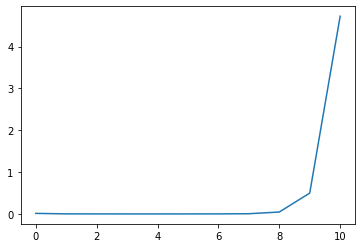

In [5]:
size = 60
mu = -0.5

u = np.random.rand(size)
v = np.random.rand(size)
eps = 0.1
err = np.zeros(11)
for idx in range(1, 12):
    eps = eps / 10
    approx = (fGL1(u + eps * v, size, mu) - fGL1(u, size, mu)) / eps
    err[idx - 1] = np.linalg.norm(approx - JacGL1(u, size, mu) @ v)
plt.plot(err)

# Computing the trivial solution to the steady-state Ginzburg-Landau equation

In [6]:
# Function that computes Newton-Rhapson iterations
# to find a zero of a function
def newton(x0, func, jac_func, tol, max_iter):
    iter = 1
    norm_dx = 2 * tol
    x = x0
    while iter < max_iter and norm_dx > tol:
        jac = jac_func(x)
        dx = - spsolve(jac_func(x), func(x))
        x += dx
        norm_dx = np.linalg.norm(dx)
        iter = iter + 1
    return x
        
def zero_of_GL1(u0, size, mu):
    tol = 1e-6
    max_iter = 15
    l_fGL1 = lambda u: fGL1(u, size, mu)
    l_JacGL1 = lambda u: JacGL1(u, size, mu)
    return newton(u0, l_fGL1, l_JacGL1, tol, max_iter)

size = 5
u0 = np.random.rand(size)
mu = -0.5

print(zero_of_GL1(u0, size, mu))

[3.30872245e-24 6.61744490e-24 1.32348898e-23 1.32348898e-23
 6.61744490e-24]
